<a href="https://colab.research.google.com/github/usef-kh/EC523-Deep-Learning-Project/blob/master/combining_subnets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set Up and Data Loading/Processing

In [1]:
!git clone "https://github.com/usef-kh/EC523-Deep-Learning-Project.git"
!pip install unrar
!unrar e "EC523-Deep-Learning-Project/datasets/fer2013.rar"

Cloning into 'EC523-Deep-Learning-Project'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 111 (delta 30), reused 6 (delta 1), pack-reused 40
Receiving objects: 100% (111/111), 180.47 MiB | 45.79 MiB/s, done.
Resolving deltas: 100% (45/45), done.

UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from EC523-Deep-Learning-Project/datasets/fer2013.rar

Extracting  fer2013.csv                                                    4%  9% 13% 18% 23% 27% 32% 37% 41% 46% 51% 55% 60% 65% 69% 74% 79% 83% 88% 93% 97% 99%  OK 
All OK


In [2]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch import optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
fer2013 = pd.read_csv('fer2013.csv') 
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
fer2013.head()

def prepare_data(data):
    """ Prepare data for modeling 
        input: data frame with labels und pixel data
        output: image and label array """
    
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label

xtrain, ytrain = prepare_data(fer2013[fer2013['Usage'] == 'Training'])
xval , yval = prepare_data(fer2013[fer2013['Usage'] == 'PrivateTest'])
xtest, ytest = prepare_data(fer2013[fer2013['Usage'] == 'PublicTest'])

In [4]:
class Fer2013(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform        
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img = Image.fromarray(self.images[idx])
        
        if self.transform:
            img = self.transform(img)

        label = torch.tensor(self.labels[idx]).type(torch.long)
        sample = (img, label)
        
        return sample

mu, st = 0, 255
train_transform = transforms.Compose([
                    transforms.RandomResizedCrop(48, scale=(0.8, 1.0)),
                    transforms.RandomAffine(0, translate=(0, 0.1)),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomRotation(10),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=mu, std = st)
                    ])

test_transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize(mean=mu, std = st)
                    ])

train = Fer2013(xtrain, ytrain, train_transform)
val = Fer2013(xval, yval, test_transform)
test = Fer2013(xtest, ytest, test_transform)

In [5]:
trainloader = torch.utils.data.DataLoader(train, batch_size=100, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val, batch_size=100, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test, batch_size=100, shuffle=True, num_workers=2)

Batch Images Shape: torch.Size([100, 1, 48, 48])
Batch Labels Shape: torch.Size([100])

  Happy     Sad   Angry    Fear     Sad


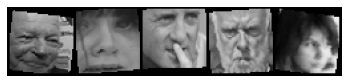

In [6]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

print("Batch Images Shape:", images.shape)
print("Batch Labels Shape:", labels.shape)
print()

# show 5 images
imshow(torchvision.utils.make_grid(images[:5]))
plt.axis('off')
# print labels
print(' '.join('%7s' % emotions[labels[j].item()] for j in range(5)))

# Combining Three Subnets

In [24]:
# All model class definitions
class Subnet1Features(nn.Module):
    def __init__(self):
        super(Subnet1Features, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)

        self.lin1 = nn.Linear(256 * 6 * 6, 4096) 
        self.lin2 = nn.Linear(4096, 4096)
        # self.lin3 = nn.Linear(4096, 7)

        self.history = History()

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)

        x = x.view(-1, 256*6*6) 
        
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        
        # x = self.lin3(x)

        return x

class Subnet2Features(nn.Module):
    def __init__(self):
        super(Subnet2Features, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1) # according to paper!
        self.conv2 = nn.Conv2d(64,128,3,padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv3_2 = nn.Conv2d(256,256, 3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)

        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn3_2 = nn.BatchNorm2d(256)
        
        self.lin1 = nn.Linear(256 * 6 * 6, 4096)
        self.lin2 = nn.Linear(4096, 4096)
        # self.lin3 = nn.Linear(4096, 7)

        self.history = History()
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn3_2(self.conv3_2(x)))
        x = self.pool(x)

        x = x.view(x.size(0), 256 * 6 * 6)

        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        
        # x = self.lin3(x)

        return x


class Subnet3Features(nn.Module):
    def __init__(self):
        super(Subnet3Features, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1) # according to paper!
        self.conv2 = nn.Conv2d(64,128,3,padding=1)
        self.conv2_2 = nn.Conv2d(128,128,3,padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv3_2 = nn.Conv2d(256,256, 3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)

        self.bn1 = nn.BatchNorm2d(num_features= 64)
        self.bn2 = nn.BatchNorm2d(num_features= 128)
        self.bn2_2 = nn.BatchNorm2d(num_features= 128)
        self.bn3 = nn.BatchNorm2d(num_features= 256)
        self.bn3_2 = nn.BatchNorm2d(num_features= 256)

        self.lin1 = nn.Linear(256 * 6 * 6, 4096)
        self.lin2 = nn.Linear(4096, 4096)
        # self.lin3 = nn.Linear(4096, 7)

        self.history = History()
        
    def forward(self, x):

        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn2_2(self.conv2_2(x)))
        x = self.pool(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn3_2(self.conv3_2(x)))
        x = self.pool(x)

        x = x.view(-1, 256*6*6)
      
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        
        # x = self.lin3(x)

        return x

In [25]:
# All model class definitions
class Subnet1(nn.Module):
    def __init__(self):
        super(Subnet1, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)

        self.lin1 = nn.Linear(256 * 6 * 6, 4096) 
        self.lin2 = nn.Linear(4096, 4096)
        self.lin3 = nn.Linear(4096, 7)

        self.history = History()

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)

        x = x.view(-1, 256*6*6) 
        
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        
        x = self.lin3(x)

        return x

class Subnet2(nn.Module):
    def __init__(self):
        super(Subnet2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1) # according to paper!
        self.conv2 = nn.Conv2d(64,128,3,padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv3_2 = nn.Conv2d(256,256, 3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)

        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn3_2 = nn.BatchNorm2d(256)
        
        self.lin1 = nn.Linear(256 * 6 * 6, 4096)
        self.lin2 = nn.Linear(4096, 4096)
        self.lin3 = nn.Linear(4096, 7)

        self.history = History()
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn3_2(self.conv3_2(x)))
        x = self.pool(x)

        x = x.view(x.size(0), 256 * 6 * 6)

        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        
        x = self.lin3(x)

        return x


class Subnet3(nn.Module):
    def __init__(self):
        super(Subnet3, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1) # according to paper!
        self.conv2 = nn.Conv2d(64,128,3,padding=1)
        self.conv2_2 = nn.Conv2d(128,128,3,padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv3_2 = nn.Conv2d(256,256, 3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)

        self.bn1 = nn.BatchNorm2d(num_features= 64)
        self.bn2 = nn.BatchNorm2d(num_features= 128)
        self.bn2_2 = nn.BatchNorm2d(num_features= 128)
        self.bn3 = nn.BatchNorm2d(num_features= 256)
        self.bn3_2 = nn.BatchNorm2d(num_features= 256)

        self.lin1 = nn.Linear(256 * 6 * 6, 4096)
        self.lin2 = nn.Linear(4096, 4096)
        self.lin3 = nn.Linear(4096, 7)

        self.history = History()
        
    def forward(self, x):

        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn2_2(self.conv2_2(x)))
        x = self.pool(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn3_2(self.conv3_2(x)))
        x = self.pool(x)

        x = x.view(-1, 256*6*6)
      
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        
        x = self.lin3(x)

        return x

In [26]:
def train_model(net, trainloader, valloader, n_epochs=20):

    for epoch in range(n_epochs):
        
        net = net.train()
        loss_tr, correct_count, n = 0.0, 0.0, 0.0
        for i, data in enumerate(trainloader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # calculate performance metrics
            loss_tr += loss.item()
            
            _, preds = torch.max(outputs.data, 1)
            correct_count += (preds == labels).sum().item()
            n += labels.size(0)
            
        # Save train and validation performance metrics 
        acc_tr = 100 * correct_count / n
        loss_tr = loss_tr / n

        acc_v, loss_v = test_model(net, valloader)

        net.history.loss_train.append(loss_tr)
        net.history.loss_val.append(loss_v)

        net.history.acc_train.append(acc_tr)
        net.history.acc_val.append(acc_v)
        
        print('Epoch %2d' % (epoch + 1), 'Train Accuracy: %2.2f %%' % (acc_tr), 'Val Accuracy: %2.2f %%' % (acc_v), sep='\t\t')

In [27]:
def test_model(net, dataloader):
    
    net = net.eval()

    loss, correct_count, n_sampels = 0.0, 0.0, 0.0
    for data in dataloader:

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)

        loss += criterion(outputs, labels).item()

        _, preds = torch.max(outputs.data, 1)
        correct_count += (preds == labels).sum().item()
        n_sampels += labels.size(0)
    
    acc = 100 * correct_count / n_sampels
    loss = loss / n_sampels
    
    return acc, loss

In [28]:
def plot_metrics(net):
    plt.figure()
    plt.plot(net.history.acc_train, 'g', label='Training Acc')
    plt.plot(net.history.acc_val, 'b', label='Validation Acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Acc')
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure()
    plt.plot(net.history.loss_train, 'g', label='Training Loss')
    plt.plot(net.history.loss_val, 'b', label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

    print('Training Accuracy: %2.2f %%' % (max(net.history.acc_train)))
    print('Validation Accuracy: %2.2f %%' % (max(net.history.acc_val)))
    print()

    acc, loss = test_model(net, testloader)    
    print('Test Accuracy: %2.2f %%' % (acc))
    print('Average Test Loss: %2.4f' % (loss))

In [29]:
class History:
    def __init__(self):
        self.loss_train = []
        self.loss_val = []

        self.acc_train = []
        self.acc_val = []

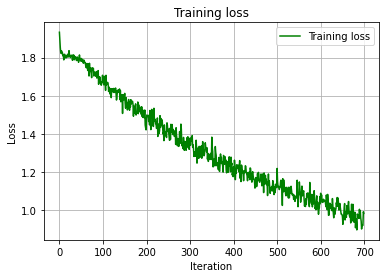

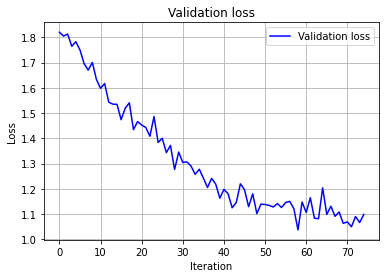

In [ ]:
plt.figure()
plt.plot(train_loss, 'g', label='Training loss')
plt.title('Training loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Validation loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [ ]:
acc = []
dataloaders = [trainloader, valloader, testloader]
for loader in dataloaders:
    acc.append(test_model(net, loader))

print('Train Accuracy: %2.2f %%' % (acc[0]))
print('Val Accuracy: %2.2f %%' % (acc[1]))
print('Test Accuracy: %2.2f %%' % (acc[2]))

Train Accuracy: 64.77 %
Val Accuracy: 59.54 %
Test Accuracy: 59.32 %


In [20]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
# load pretrained models completeley
pretrained_1 = Subnet1()
pretrained_1.load_state_dict(torch.load('/content/drive/Shared drives/EC523 Project/CNN Ensemble/Tuned Subnets/sub1'))
pretrained_1.eval()

pretrained_2 = Subnet2()
pretrained_2.load_state_dict(torch.load('/content/drive/Shared drives/EC523 Project/CNN Ensemble/Tuned Subnets/sub2'))
pretrained_2.eval()

pretrained_3 = Subnet3()
pretrained_3.load_state_dict(torch.load('/content/drive/Shared drives/EC523 Project/CNN Ensemble/Tuned Subnets/sub3'))
pretrained_3.eval()

# figure out the layers

Subnet3(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3_2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lin1): Linear(in_features=9216, out_features=4096, bias

In [42]:
def load_layers(pretrained, model):
    pretrained = pretrained.state_dict()

    model_dict = model.state_dict()
    # print(model_dict)


    # 1. filter out unnecessary keys
    pretrained = {k: v for k, v in pretrained.items() if k in model_dict}
    # 2. overwrite entries in the existing state dict
    model_dict.update(pretrained) 
    # 3. load the new state dict
    model.load_state_dict(pretrained)

    for name, param in model.named_parameters():
        param.requires_grad = False

    return model


In [43]:
sub1_f = Subnet1Features()
sub2_f = Subnet2Features()
sub3_f = Subnet3Features()

subnet1 = load_layers(pretrained_1, sub1_f)
subnet2 = load_layers(pretrained_2, sub2_f)
subnet3 = load_layers(pretrained_3, sub3_f)


In [48]:
class CombinedNetsPretrained(nn.Module):
    def __init__(self, subnet1, subnet2, subnet3):
        super(CombinedNetsPretrained, self).__init__()
        # pass in FROZEN subnets!!
        # for net 1
        self.sub1 = subnet1

        self.sub2 = subnet2

        self.sub3 = subnet3
        # for net2

        self.history = History()

        self.final_lin = nn.Linear(4096*3, 7)

    def forward(self, x):
        x_1 = self.sub1(x)
        x_2 = self.sub2(x)
        x_3 = self.sub3(x)

        # concatenate x_1, x_2, x_3
        #third_tensor= tf.concat(0, [first_tensor, second_tensor])

        #print(x_1.shape, x_2.shape, x_3.shape)

        x_cat = torch.cat((x_1, x_2, x_3), dim=1)

        #print(x_cat.shape)
        #input("Type E to continue...")

        x = self.final_lin(x_cat)

        return x

net = CombinedNetsPretrained(subnet1,subnet2,subnet3)
net = net.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
train_model(net, trainloader, valloader, n_epochs=5)

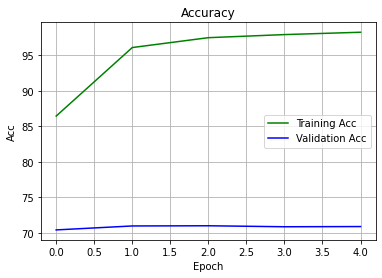

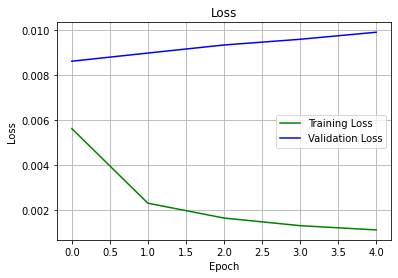

Training Accuracy: 98.27 %
Validation Accuracy: 70.99 %

Test Accuracy: 69.07 %
Average Test Loss: 0.0107


In [50]:
plot_metrics(net)